In [145]:
import sys
sys.path.append(r'D:\python\finace')
from libs import MyEngine
import pandas as pd
import seaborn as sns
#coding:utf-8
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

# 因子选股：
## 找出股票
- 交易量翻倍  k =  2
- 交易额进入前 turnover_rank = 100

In [146]:
sql = 'select stock_code, date, volume, open_price, close_price, turnover, turnover_rate, price_change_percentage from stock_zh_a_hist_daily where date between "2024-07-20" and "2024-08-20"'
one_month_data = MyEngine().read_sql_query(sql)

In [147]:
k = 5
turnover_rank = 1000

one_month_data.sort_values(by=['stock_code', 'date'], inplace=True, ascending=True)
one_month_data['volume_next_day'] = one_month_data.groupby(['stock_code'])['volume'].shift(-1)
one_month_data['volume_last_day'] = one_month_data.groupby(['stock_code'])['volume'].shift(1)
one_month_data['close_price_next_days'] = one_month_data.groupby(['stock_code'])['close_price'].shift(-5)
one_month_data.dropna(inplace=True)
one_month_data['cumsum_return_next_days'] = (one_month_data['close_price_next_days']-one_month_data['close_price'])/one_month_data['close_price']*100
one_month_data['volume_rate'] = 2 *  one_month_data['volume_next_day'] /  (one_month_data['volume_last_day'] + one_month_data['volume'])
res = []
plot_df = []
for date, dfg in one_month_data.groupby(['date']):
    high_volume_rate = dfg[dfg['volume_rate']>k]['stock_code'].values
    dfg.sort_values(by=['turnover'], inplace=True, ascending=False)
    high_turnover = dfg.iloc[:turnover_rank, :]['stock_code'].values
    res_code = [i for i in high_volume_rate if i in high_turnover]
    res.extend(res_code)

    temp = dfg[dfg['volume_rate']>k]
    temp = temp[temp['stock_code'].isin(high_turnover)]
    # temp = temp[temp['price_change_percentage']>2]
    if isinstance(plot_df, list):
        plot_df = temp
    else:
        plot_df = pd.concat([plot_df, temp])    

res = list(set(res))

## 策略绘图

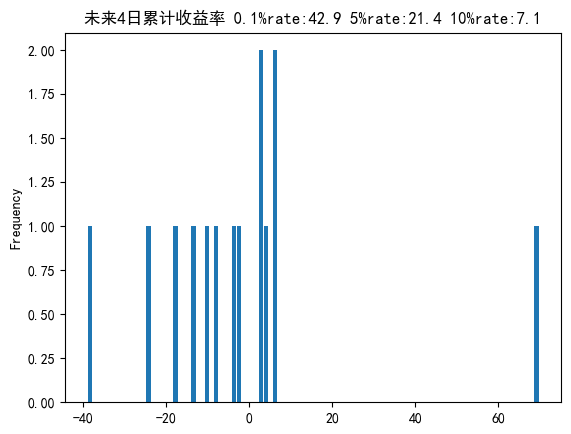

In [148]:
name = f'volume_rate_k{k}_turnover_rank{turnover_rank}'
Path(f'./figs/{name}').mkdir(exist_ok=True, parents=True)
plot_df.sort_values(by=['cumsum_return_next_days'], inplace=True, ascending=False)
temp = plot_df[plot_df['cumsum_return_next_days']<100]
temp = temp[temp['cumsum_return_next_days']>-100]
rate_1 = temp[temp['cumsum_return_next_days']>0.1].shape[0]/temp.shape[0]*100
rate_5 = temp[temp['cumsum_return_next_days']>5].shape[0]/temp.shape[0]*100
rate_10 = temp[temp['cumsum_return_next_days']>10].shape[0]/temp.shape[0]*100
temp['cumsum_return_next_days'].plot.hist(title=f'未来4日累计收益率 0.1%rate:{rate_1:.1f} 5%rate:{rate_5:.1f} 10%rate:{rate_10:.1f}', rwidth=0.95, bins=100)
plt.savefig(f'./figs/{name}/stat_earning.png')

In [149]:
# one_month_data['date'] = pd.to_datetime(one_month_data['date'])
# for i in res:
#     temp = one_month_data[one_month_data['stock_code']==i]
#     ax = temp.plot(x='date', y=['open_price', 'close_price', 'volume_rate', 'turnover', 'cumsum_return_next_days'], kind='line', subplots=True, sharex=True)
#     # temp.plot(x='date', y=['volume_rate'], kind='line', ax=axes[1])
#     # temp.plot(x='date', y=['turnover'], kind='line', ax=axes[2])
#     earning = plot_df[plot_df['stock_code']==i]['cumsum_return_next_days'].iloc[0]
#     ax[0].set_title(f'股票：{i}  交易量倍数：{k} 交易额排名（top）:{turnover_rank} 未来4日累计收益率：{earning:.1f}')
#     Path(f'./figs/{name}').mkdir(exist_ok=True, parents=True)
#     plt.savefig(f'./figs/{name}/{earning:.1f}_{i}.png')
#     plt.close()
#     plt.clf()
